In [ ]:
from IPython.core.display import display, HTML
import GPy, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(precision=4, linewidth=200)

# Theory
This notebook demonstrates how to use derivative observations and derivative sign observations with GP regression.

Assume that we have observations $\mathbf{y} = \{y^{(i)} \}_{i=1}^{N}$ from an unkown noisy latent process ($y^{(i)} = f(\mathbf{x}^{(i)}) + \epsilon^{(i)}$), from known locations $\mathbf{X} = \{\mathbf{x}^{(i)}\}_{i=1}^N$. We may assume that the noise follows any distribution.

When handling derivative observations, we know something about the derivative values of the latent variables, this means that we have (possibly) noisy observations $\tilde{\mathbf{y}} =  \{ \tilde{y}^{(i)} \}_{i=1}^M$ from the partial derivatives of the latent process ($\tilde{y}^{(i)} = \frac{\partial f(\tilde{\mathbf{x}}^{(i)})}{\partial \tilde{\mathbf{x}}^{(i)}_g} + \epsilon_g^{(i)}$) from some known locations $\tilde{\mathbf{X}} = \{\tilde{\mathbf{x}}^{(i)}\}_{i=1}^M$. Again, the noise may follow any distribution.

As always, in GP regression, we assume that the observations have a Gaussian Process prior and are interested in the posterior distribution of the latent variables $f = f(\mathbf{x})$ and latent variable derivatives $\tilde{f} = \frac{\partial f(\tilde{\mathbf{x}})}{\partial \tilde{\mathbf{x}}_g }$ given some input locations can be derived from the Bayes' rule
\begin{equation}
\begin{aligned}
&p(\mathbf{f}, \mathbf{\tilde{f}}\,|\,\mathbf{y}, \tilde{\mathbf{y}}, \mathbf{X}, \tilde{\mathbf{X}}) = \frac{p(\mathbf{f}, \mathbf{\tilde{f}}\,|\, \mathbf{X}, \tilde{\mathbf{X}})p(\mathbf{y} \,|\,\mathbf{f})p(\tilde{\mathbf{y}}\,|\,\tilde{\mathbf{f}})}{Z},
\end{aligned}
\end{equation}
with the marginal likelihood
\begin{equation*}
\begin{aligned}
&Z= p(\mathbf{y},\tilde{\mathbf{y}} \, |\, \mathbf{X}, \mathbf{\tilde{\mathbf{X}}}) \\ &=\int\! p(\mathbf{f}, \tilde{\mathbf{f}}| \mathbf{X}, \tilde{\mathbf{X}})p(\mathbf{y} \,|\, \mathbf{f})p(\tilde{\mathbf{y}} \,|\, \tilde{\mathbf{f}}) \text{d} \mathbf{f} \text{d} \tilde{\mathbf{f}}.
\end{aligned}
\end{equation*}

In above, we need to know two new distributions:

1. The joint distribution of the latent variables $p(\mathbf{f}, \tilde{\mathbf{f}}\,|\, \mathbf{X}, \tilde{\mathbf{X}})$. Let us first consider the joint distribution of the latent variables. With a Gaussian process prior:\begin{equation} \begin{aligned}
&p\left(\left[ \begin{matrix} \mathbf{f} \\ \mathbf{\tilde{f}} \end{matrix} \right]\,  \middle| \, \left[\begin{matrix} \mathbf{X} \\ \mathbf{\tilde{X}}\end{matrix} \right]\right)   =    \text{N} \left(\left[ \begin{matrix} \mathbf{f} \\ \tilde{\mathbf{f}} \end{matrix} \right]\, \middle| \, m\left( \left[ \begin{matrix} \mathbf{f} \\ \tilde{\mathbf{f}} \end{matrix} \right] \right), \left[ \begin{matrix} \mathbf{K_{f, f}} & \mathbf{K_{f, \tilde{f}}}  \\ \mathbf{K_{ \tilde{f},f}} & \mathbf{K_{ \tilde{f}, \tilde{f}}} \end{matrix} \right]\right).
\end{aligned}
\end{equation}
We need to know the covariances between the latent functions values and their partial derivatives and two partial derivatives. However, this is straightforward as:
\begin{align*}
\text{cov} \left({ \frac{\partial f^{(i)}}{\partial x^{(i)}_g}, \; f^{(j)} }\right) &= \frac{ \partial }{\partial x^{(i)}_g}\; \text{cov}\left({ f^{(i)}, \; f^{(j)}}\right), \\
\text{cov}\left({ \frac{ \partial f^{(i)}}{ \partial x^{(i)}_g}, \; \frac{ \partial f^{(j)}}{ \partial x^{(j)}_h} }\right) &= \frac{\partial^2 }{\partial x^{(i)}_g \partial x^{(j)}_h  }\; \text{cov}\left({ f^{(i)}, \; f^{(j)}}\right)
\end{align*}
Thus, we only need to know the first and second derivatives of the covariance function with respect to $\mathbf{x}$.

2. The likelihood of the derivative observations $p(\tilde{\mathbf{y}} \,|\, \tilde{\mathbf{f}})$. We may assume any likelihood for the derivative observations. How ever, two likelihoods are the most used:
     1. Gaussian likelihood: 
    \begin{equation} 
    p(\tilde{\mathbf{y}} \,|\, \tilde{\mathbf{f}}) = \prod_{i=1}^M \text{N}(\tilde{y}^{(i)}|\tilde{f}^{(i)}, \sigma^2 ) 
    \end{equation}
     2. Probit likelihood with a tuning parameter:
    \begin{equation} 
    p(\tilde{\mathbf{y}} \,|\, \tilde{\mathbf{f}}) = \prod_{i=1}^M \boldsymbol{\Phi} \left( \nu \tilde{ y}^{(i)} \tilde{f}^{(i)} \right),
    \end{equation}
    where $\nu$ is a tuning parameter and $\boldsymbol{\Phi} \left(x \right) = \int_{-\infty}^x \text{N} \left( \bar{x} \,|\, 0,1\right) \text{d} \bar{x}$ 

# Example 1:  1 dimensional data with direct derivative observations

Let us first generate the data:

In [2]:
f = lambda x: np.sin(x)+0.1*(x-2.)**2-0.005*x**3
fd = lambda x: np.cos(x)+0.2*(x-2.)-0.015*x**2
N=5
M=5
sigma=0.05
sigmader = 0.05
x = np.array([np.linspace(1,10,N)]).T
y = f(x) + np.array(sigma*np.random.normal(0,1,(N,1)))

xd = np.array([np.linspace(2,8,M)]).T
yd = fd(xd) + np.array(sigmader*np.random.normal(0,1,(M,1)))

xpred = np.array([np.linspace(0,11,100)]).T
ypred = f(xpred)
ydpred = fd(xpred)

And let us then generate the model:


Name : gp
Objective : 11.026371493165243
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                                  |   value  |  constraints  |  priors
  MultioutputKern.rbf.variance         |     0.2  |      +ve      |        
  MultioutputKern.rbf.lengthscale      |     1.5  |      +ve      |        
  mixed_noise.Gaussian_noise.variance  |  0.0025  |      +ve      |        

Name : gp
Objective : 3.1832721710256893
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                                  |             value  |  constraints  |  priors
  MultioutputKern.rbf.variance         |     1.57393121989  |      +ve      |        
  MultioutputKern.rbf.lengthscale      |     2.16189215534  |      +ve      |        
  mixed_noise.Gaussian_noise.variance  |  0.00302678622078  |      +ve      |        


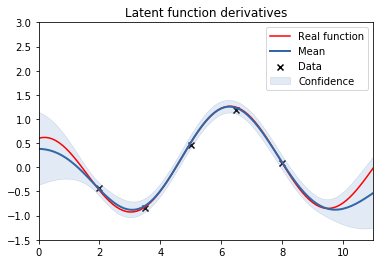

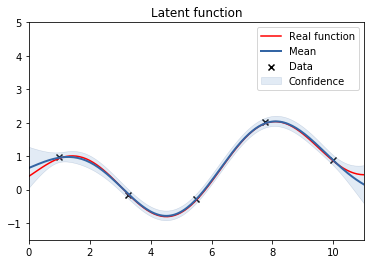

In [3]:
# squared exponential kernel:
se = GPy.kern.RBF(input_dim = 1, lengthscale=1.5, variance=0.2)
# We need to generate separate kernel for the derivative observations and give the created kernel as an input:
se_der = GPy.kern.DiffKern(se, 0)

#Then 
gauss = GPy.likelihoods.Gaussian(variance=sigma**2)
gauss_der = GPy.likelihoods.Gaussian(variance=sigma**2)

# Then create the model, we give everything in lists, the order of the inputs indicates the order of the outputs
# Now we have the regular observations first and derivative observations second, meaning that the kernels and
# the likelihoods must follow the same order
m = GPy.core.MultioutputGP(X_list=[x, xd], Y_list=[y, yd], kernel_list=[se, se_der], likelihood_list = [gauss, gauss])

#Print the model before optimization
print(m)

# Optimize the model
m.optimize(messages=1, ipython_notebook=True)
 # Print the model after optimization
print(m)

#Plot the model, the syntax is same as for multioutput models:
#Derivatives:


fig, ax = plt.subplots()
ax.set_title('Latent function derivatives')
plt.plot(xpred, ydpred, "r", label='Real function')
m.plot(fixed_inputs=[(1,1)], which_data_rows=slice(x.shape[0],x.shape[0]+xd.shape[0]), xlim=[0,11],ylim=[-1.5,3], ax=ax)
#Observations

fig, ax = plt.subplots()
ax.set_title('Latent function')
plt.plot(xpred, ypred, "r", label='Real function')
m.plot(fixed_inputs=[(1,0)], which_data_rows=slice(0,x.shape[0]), xlim=[0,11], ylim=[-1.5,5], ax=ax)

#making predictions for the values:
mu, var = m.predict_noiseless(Xnew=[xpred, np.empty((0,1))])

And for comparison, without derivative observations:


Name : gp
Objective : 15.190633473995138
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                                  |   value  |  constraints  |  priors
  MultioutputKern.rbf.variance         |     0.2  |      +ve      |        
  MultioutputKern.rbf.lengthscale      |     1.5  |      +ve      |        
  mixed_noise.Gaussian_noise.variance  |  0.0025  |      +ve      |        

Name : gp
Objective : 7.317066572168162
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                                  |             value  |  constraints  |  priors
  MultioutputKern.rbf.variance         |     1.19095866251  |      +ve      |        
  MultioutputKern.rbf.lengthscale      |     1.47516715091  |      +ve      |        
  mixed_noise.Gaussian_noise.variance  |  0.00254450295837  |      +ve      |        


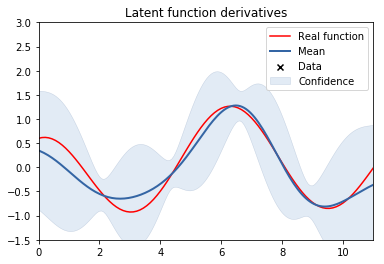

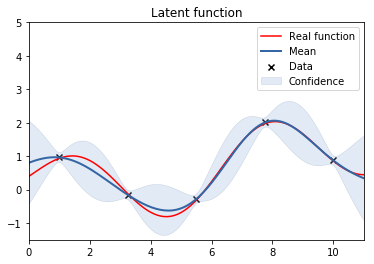

In [4]:
# squared exponential kernel:
se = GPy.kern.RBF(input_dim = 1, lengthscale=1.5, variance=0.2)
# We need to generate separate kernel for the derivative observations and give the created kernel as an input:
se_der = GPy.kern.DiffKern(se, 0)

#Then 
gauss = GPy.likelihoods.Gaussian(variance=sigma**2)

# Then create the model, we give everything in lists
m = GPy.core.MultioutputGP(X_list=[x, np.empty((0,1))], Y_list=[y, np.empty((0,1))], kernel_list=[se, se_der], likelihood_list = [gauss, gauss])

#Print the model before optimization
print(m)

# Optimize the model
m.optimize(messages=1, ipython_notebook=True)
 # Print the model after optimization
print(m)

#Plot the model, the syntax is same as for multioutput models:
#Derivatives:


fig, ax = plt.subplots()
ax.set_title('Latent function derivatives')
plt.plot(xpred, ydpred, "r", label='Real function')
m.plot(fixed_inputs=[(1,1)], which_data_rows=slice(0,0), xlim=[0,11],ylim=[-1.5,3], ax=ax)
#Observations

fig, ax = plt.subplots()
ax.set_title('Latent function')
plt.plot(xpred, ypred, "r", label='Real function')
m.plot(fixed_inputs=[(1,0)], which_data_rows=slice(0,x.shape[0]), xlim=[0,11], ylim=[-1.5,5], ax=ax)

In [5]:
# Example 2:  1 dimensional data with monotonicity information

In [6]:
M=7
xd = np.array([np.linspace(2,8,M)]).T
yd = 2*(fd(xd)>0) -1


Name : gp
Objective : 15.661037437456116
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                  |   value  |     constraints      |  priors
  MultioutputKern.rbf.variance         |     0.2  |         +ve          |        
  MultioutputKern.rbf.lengthscale      |     1.5  |         +ve          |        
  mixed_noise.Gaussian_noise.variance  |  0.0025  |         +ve          |        
  mixed_noise.Binomial.Probit.nu       |   100.0  |  -100000.0,100000.0  |        

Name : gp
Objective : 7.894516774220392
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                  |              value  |     constraints      |  priors
  MultioutputKern.rbf.variance         |      1.41770051037  |         +ve          |        
  MultioutputKern.rbf.lengthscale      |      1.91173491364  |         +ve          |        
  mixed_noise.Gaussian_noise.variance  |

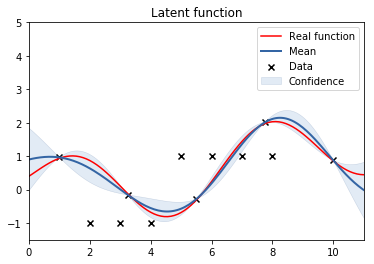

In [7]:
# squared exponential kernel:
se = GPy.kern.RBF(input_dim = 1, lengthscale=1.5, variance=0.2)
# We need to generate separate kernel for the derivative observations and give the created kernel as an input:
se_der = GPy.kern.DiffKern(se, 0)

#Then 
gauss = GPy.likelihoods.Gaussian(variance=sigma**2)
probit = GPy.likelihoods.Binomial(gp_link = GPy.likelihoods.link_functions.Probit(nu=100, fixed=False))

# Then create the model, we give everything in lists
m = GPy.core.MultioutputGP(X_list=[x, xd], Y_list=[y, yd], kernel_list=[se, se_der], likelihood_list = [gauss, probit], inference_method=GPy.inference.latent_function_inference.EP(ep_mode="nested"))

#Print the model before optimization
print(m)
# Optimize the model
m.optimize(messages=1, ipython_notebook=True)
 # Print the model after optimization
print(m)

#Plot the model, the syntax is same as for multioutput models:
#Derivatives:


#fig, ax = plt.subplots()
#ax.set_title('Latent function derivatives')
#plt.plot(xpred, ydpred, "r", label='Real function')
#m.plot(fixed_inputs=[(1,1)], which_data_rows=slice(x.shape[0],x.shape[0]+xd.shape[0]), xlim=[0,11],ylim=[-1.5,3], ax=ax)
#Observations

fig, ax = plt.subplots()
ax.set_title('Latent function')
plt.plot(xpred, ypred, "r", label='Real function')
m.plot(fixed_inputs=[(1,0)], xlim=[0,11], ylim=[-1.5,5], ax=ax) # which_data_rows=slice(0,x.shape[0])


Name : gp
Objective : 15.190633473995138
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |   value  |  constraints  |  priors
  rbf.variance             |     0.2  |      +ve      |        
  rbf.lengthscale          |     1.5  |      +ve      |        
  Gaussian_noise.variance  |  0.0025  |      +ve      |        

Name : gp
Objective : 7.317066572168162
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |             value  |  constraints  |  priors
  rbf.variance             |     1.19095866251  |      +ve      |        
  rbf.lengthscale          |     1.47516715091  |      +ve      |        
  Gaussian_noise.variance  |  0.00254450295837  |      +ve      |        


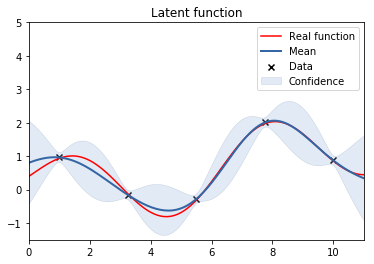

In [8]:
# squared exponential kernel:
se = GPy.kern.RBF(input_dim = 1, lengthscale=1.5, variance=0.2)

#Then 
gauss = GPy.likelihoods.Gaussian(variance=sigma**2)

# Then create the model, we give everything in lists
m = GPy.core.GP(x, y, kernel = se, likelihood = gauss)

#Print the model before optimization
print(m)

# Optimize the model
m.optimize(messages=1, ipython_notebook=True)
 # Print the model after optimization
print(m)

#Plot the model, the syntax is same as for multioutput models:
#Derivatives:


#fig, ax = plt.subplots()
#ax.set_title('Latent function derivatives')
#plt.plot(xpred, ydpred, "r", label='Real function')
#m.plot(fixed_inputs=[(1,1)], which_data_rows=slice(x.shape[0],x.shape[0]+xd.shape[0]), xlim=[0,11],ylim=[-1.5,3], ax=ax)
#Observations

fig, ax = plt.subplots()
ax.set_title('Latent function')
plt.plot(xpred, ypred, "r", label='Real function')
m.plot(xlim=[0,11], ylim=[-1.5,5], ax=ax)

In [9]:
# squared exponential kernel:
se = GPy.kern.RBF(input_dim = 1, lengthscale=1.5, variance=0.2)
# We need to generate separate kernel for the derivative observations and give the created kernel as an input:
se_der = GPy.kern.DiffKern(se, 0)

#Then 
gauss = GPy.likelihoods.Gaussian(variance=sigma**2)
probit = GPy.likelihoods.Binomial(gp_link = GPy.likelihoods.link_functions.Probit(nu=10, fixed=True))

# Then create the model, we give everything in lists
#m = GPy.core.MultioutputGP(X_list=[x, xd], Y_list=[y, yd], kernel_list=[se, se_der], likelihood_list = [gauss, probit], inference_method=GPy.inference.latent_function_inference.Laplace())
m = GPy.core.MultioutputGP(X_list=[x], Y_list=[y], kernel_list=[se], likelihood_list = [gauss], inference_method=GPy.inference.latent_function_inference.Laplace())
#m = GPy.core.GP(x,y, kernel=se, likelihood = gauss, inference_method=GPy.inference.latent_function_inference.Laplace())

#Print the model before optimization
print(m)

# Optimize the model
m.optimize(messages=1, ipython_notebook=True)
 # Print the model after optimization
print(m)

#Plot the model, the syntax is same as for multioutput models:
#Derivatives:


#fig, ax = plt.subplots()
#ax.set_title('Latent function derivatives')
#plt.plot(xpred, ydpred, "r", label='Real function')
#m.plot(fixed_inputs=[(1,1)], which_data_rows=slice(x.shape[0],x.shape[0]+xd.shape[0]), xlim=[0,11],ylim=[-1.5,3], ax=ax)
#Observations

fig, ax = plt.subplots()
ax.set_title('Latent function')
plt.plot(xpred, ypred, "r", label='Real function')
#m.plot(fixed_inputs=[(1,0)], xlim=[0,11], ylim=[-1.5,5], ax=ax) # which_data_rows=slice(0,x.shape[0])
m.plot()

 /home/esiivola/Documents/git/GPy/GPy/likelihoods/mixed_noise.py:163: VisibleDeprecationWarning:boolean index did not match indexed array along dimension 0; dimension is 25 but corresponding boolean dimension is 5


ValueError: NumPy boolean array indexing assignment cannot assign 25 input values to the 5 output values where the mask is true